<h1 align="center">BDA Project: Gene Cluster Analysis Using Single cell RNA-sequencing</h1>
<h4 align="center">Casper Kaae Sønderby (casperkaae@gmail.com) and Lars Maaløe (larsma@dtu.dk)</h4>


## Introduction

Single-cell RNA sequencing measures RNA-expression levels for individual cells allowing identification of RNA-expression in cell subpopulations. The goal of this study is to cluster the single cell expression profiles into clusters using probabilistic modelling and see if these resemblance clusters produced by a skilled bioinformatician.

The clustering produced by the bioinformatician is seen below. Some clustering can be seen, however the data also appears relatively noisy

<img src="figures/bioinf_clusters.png",width=800>
### Dataset

The data is obtained from single-cell RNA sequencing of bone marrow from mice. The reads were mapped to the mice genome and each read mapping to a gene were measured as a *count* for the corresponding gene. Data were measured for 1500 samples and ≈27000 genes. We selected a subset of 48 interesting genes for further study based on a previous  litterature study. Secondly we were also provided with cell-type labels calculated using the method presented in [Franziska et. al. 2015].

#### Dataset analysis
Due to low amounts of RNA in a single living cell, the dataset is very sparse with 95% of the genes (in the filtered dataset) having a count of zero and approximately 5.5 counts per sample on average.

<img src="figures/histogram.png",width=400>

Using the tSNE dimensionality reduction algorithm we visualized the complete dataset (27000 genes) and the filtered dataset (48 genes) as seen below. The non-filtered dataset have almost no structure whereas some structure is seen for the filtered dataset. Secondly we also see that the computed cell-type labels show no agreement with the structure in the filtered dataset suggesting that these should not be trusted.
<img src="figures/tsne_all.png",width=400>
<img src="figures/tsne_filtered.png",width=400>






## Method

The latent Dirichlet allocation model (LDA) by [Blei et al. 2003] can be seen as an unsupervised model for cluster analysis. LDA is a generative model that from a *hidden* representation optimizes its posterior in order to explain the observed data points. The observed data is perceived as continues count data where each feature is expected to be exchangeable. The model is referred to as a topic model, since it segments the input data points into a latent topic distribution, which is a multinomial representation of the probability of an input data point being in each of $K$ topics. The segmentation into topics, can be perceived as clusters in a $K$-dimensional output space (e.g. euclidian) and be analyzed with various similarity/distance measurements.

To explain each variable of the LDA model we use the terminology of topic modeling for documents. In the model we have (i) $\alpha$ Dirichlet prior over the topic distribution of each document, (ii) $\beta$ Dirichlet prior over the word distribution for each topic, (iii) $\theta_i$ the multinomial topic distribution for a document $i$ with length $N$, (iv) $\rho_k$ the word distribution for a topic $k$, (v) $z^k_{ij}$ the topic $k$ for the $i^{th}$ document and the $j^{th}$ word, (vi) $w_{ij}$ is the $j^{th}$ word in document $i$. The plate notation for the model is:

<img src="figures/lda.png",width=600>

From [Blei et al. 2003] we find that the joint probility for $\theta_i$ and $z^k_{ij}$ and $w_{ij}$ is given by:
$$
p(\theta, z, w|\alpha, \beta) = p(\theta|\alpha) \Pi_{n=1}^{N} p(z_n|\theta)p(w_n|z_n,\beta) \ .
$$

The corresponding probability of a word $w_{ij}$ is given by (note the infeasible integral over $\theta$):

$$
p(w|\alpha, \beta) = \Pi_{d=1}^M \int p(\theta_d|\alpha) \bigg (\Pi^{N_d}_{n=1} \sum_{z_{dn}}p(z_{dn}|\theta_d)p(w_{dn}|z_{dn},\beta) \bigg ) d\theta_d \ .
$$

The probability of the whole corpus is the given by the product over all documents of the above.

In this implementation of the LDA model we tread $K$ as a fixed hyper parameter. For the $\alpha$ and $\beta$ priors we test symmetric and asymmetric settings.

In [36]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import gzip
import cPickle as cpkl
import seaborn as sns
import pandas as pd
import cPickle as cpkl
import pandas as pd

ntopics = 5

#due to size constraints we load the stan results where the samples have been averaged out (file with samples >200mb)
with open('stan_results.cpkl','r') as f:
    stan_data = cpkl.load(f)
    
with open('preprocessed_data.cpkl','r') as f:
    data = cpkl.load(f)
    
genes = data['genes']
t_train = data['t_train']
x_train = data['x_train']
words = data['words']
sampleid = data['sampleid']
    
theta_uni = stan_data['theta_uni']
phi_uni = stan_data['phi_uni']

theta_infor = stan_data['theta_infor']
phi_infor = stan_data['phi_infor']


## Results

We are going to use Stan and Gensim (Python package) to train the LDA model. Stan uses Hamiltonian Monte Carlo and Gensim uses an online variational Bayes approach based upon the Expectation-Maximization algorithm. So the results can potentially be different.

###STAN

We fitted two different LDA models using stan.
 * Uniform prior: This models used a flat prior on the word distribution (alpha)
 * Informative prior: This models used the background count frequencies as the prior for the count distribution (alpha)

#### Convergenve statistics

Due to long runtime the stan simulation was performed with 2000 samples and 4 chains with only 5 topics. Below is seen a table of the MCMC convergence statistics. (values in parenthesis is STD variation). The results suggests that

 * a) The effective number of samples (n_eff) is low and highly variable suggesting poor convergence
 * b) Rhat is relative high (not close to 1.0) suggeesting that more chains could be beneficial

| Parameter                   | N_eff   | Rhat   | 
|--------|----:|----:|
|Theta - Uniform prior        |44.2 (91.1) |1.5 |
|Phi - Uniform prior        |43.82 (152.8) |1.5 |
|Theta - informative prior     |21.1 (24.9) |1.5 |
|Phi - informative prior     |23.7 (87.9)  |1.5 |

Overall the STAN convergene statistics show that the models are not completely converged why the results might be misleading



In [28]:
#STAN models (The models where run on servers due to high runtime (>10 hours))
LDA_model = """

data {
  int<lower=2> K;               // num topics
  int<lower=2> V;               // num words
  int<lower=1> M;               // num docs
  int<lower=1> N;               // total word instances
  int<lower=1,upper=V> w[N];    // word n
  int<lower=1,upper=M> doc[N];  // doc ID for word n
  vector<lower=0>[K] alpha;     // topic prior
  vector<lower=0>[V] beta;      // word prior
}
parameters {
  simplex[K] theta[M];   // topic dist for doc m
  simplex[V] phi[K];     // word dist for topic k
}
model {
  for (m in 1:M)  
    theta[m] ~ dirichlet(alpha);  // prior
  for (k in 1:K)  
    phi[k] ~ dirichlet(beta);     // prior
  for (n in 1:N) {
    real gamma[K];
    for (k in 1:K) 
      gamma[k] <- log(theta[doc[n],k]) + log(phi[k,w[n]]);
    increment_log_prob(log_sum_exp(gamma));  // likelihood
  }
}
"""


#### STAN LDA topics

Below are seen heatmaps of the estimated expression for the five fitted topics of the STAN models. We see that

 * 1) The expression of a few genes seems to dominate the topics (noteably Hbb-b1).
 * 2) The topics appear relatively similar which suggests that the structure of the data have not been well captured

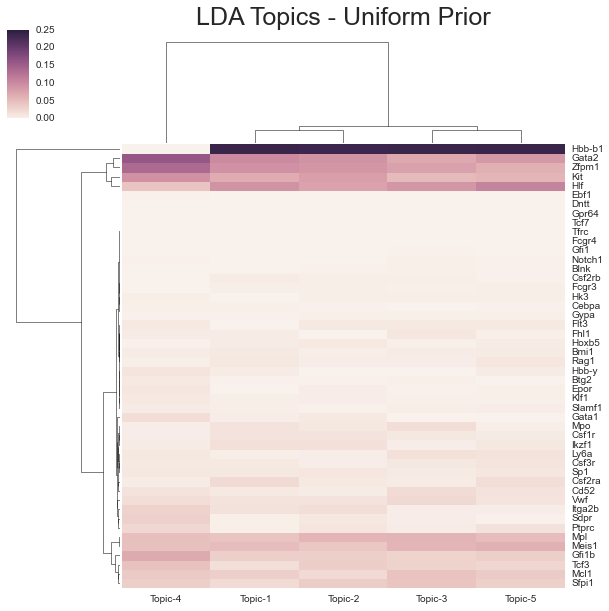

In [29]:
data = pd.DataFrame(data=phi_uni.T,index=genes, columns=['Topic-1','Topic-2','Topic-3','Topic-4','Topic-5'])
cg = sns.clustermap(data,vmax=0.25,metric='euclidean',col_cluster=True,row_cluster=True)
out = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_col_dendrogram.set_title('LDA Topics - Uniform Prior',size=25)

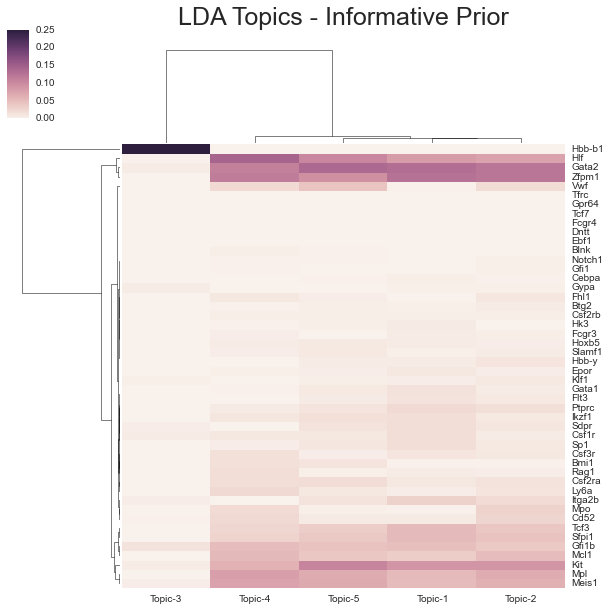

In [30]:
data = pd.DataFrame(data=phi_infor.T,index=genes, columns=['Topic-1','Topic-2','Topic-3','Topic-4','Topic-5'])
cg = sns.clustermap(data,vmax=0.25,metric='euclidean',col_cluster=True,row_cluster=True)
out = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_col_dendrogram.set_title('LDA Topics - Informative Prior',size=25)

### Gensim

Gensim is intended for end-to-end training on documents, thus we are representing the dataset as strings. We try to increase the number of topics to 10, in order to see whether the granularity of the internal clusters will thereby be more present. We also try to model the dataset by removing the Hbb-b1 gene expression that seemed to dominate the topics for the Stan modeling. Since the choice of prior in the Stan modeling did not make any big difference, we chose the Gensim auto prior that learns a prior directly from the data.

In [31]:
from gensim import corpora, models, similarities
ntopics = 10
X = x_train
print "Removing Hbb-b1..."
X[:, 11] = 0.

print "Writing dataset into a document..."
gene_docs = []
for i in range(X.shape[0]):
    c = X[i]
    g = ""
    for j in range(len(c)):
        for k in range(c[j]):
            g += genes[j] + " "
    gene_docs += [g[:-1]]

print "Initializing a Gensim corpus and dictionary..."
texts = [[word for word in document.split()] for document in gene_docs]
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/genes.dict')
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('/tmp/genes.mm', corpus)

Removing Hbb-b1...
Writing dataset into a document...
Initializing a Gensim corpus and dictionary...


In [32]:
print ""
import logging, gensim, bz2, sys, os
log_path = "lda_out.log"
try: os.remove(log_path)
except: pass
logger = logging.getLogger('gensim.models.ldamodel')
for hdlr in logger.handlers: logger.removeHandler(hdlr)
logger.handlers = []
hdlr = logging.FileHandler(log_path)
formatter = logging.Formatter('%(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.INFO)

dictionary = gensim.corpora.Dictionary.load('/tmp/genes.dict')
mm = gensim.corpora.MmCorpus('/tmp/genes.mm')
print "Corpus statistics: " + str(mm)




Corpus statistics: MmCorpus(1430 documents, 47 features, 5733 non-zero entries)


In [33]:
lda = gensim.models.ldamodel.LdaModel(corpus=mm, 
                                      id2word=dictionary, 
                                      num_topics=ntopics,
                                      passes=50, 
                                      update_every=1,
                                      chunksize=2000,
                                      alpha='auto', 
                                      eta='auto', 
                                      decay=0.5, 
                                      offset=1.0,
                                      eval_every=1, 
                                      iterations=200, 
                                      gamma_threshold=0.001,
                                      minimum_probability=0.01)

INFO:gensim.models.ldamodel:using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
INFO:gensim.models.ldamodel:using autotuned eta, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 10 topics, 50 passes over the supplied corpus of 1430 documents, updating model once every 1430 documents, evaluating perplexity every 1430 documents, iterating 200x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-4.916 per-word bound, 30.2 perplexity estimate based on a held-out corpus of 1430 documents

Extracting the training statistics...


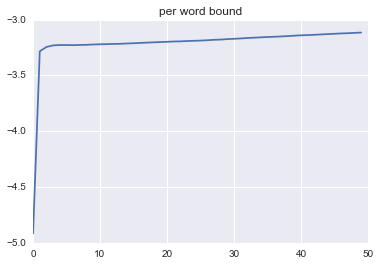

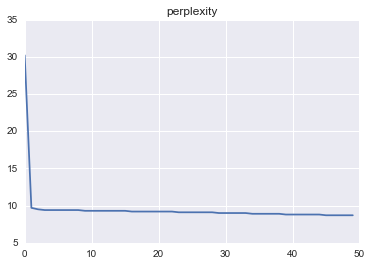

In [34]:
print "Extracting the training statistics..."
log = open(log_path).readlines()
bounds = []
perplexities = []
for line in log[4:]:
    if line.startswith("-"):
        per_word_bound = float(line[:6])
        perplexity = float(line.split(",")[1][1:5])
        bounds += [per_word_bound]
        perplexities += [perplexity]

plt.figure()
plt.title("per word bound")
plt.plot(bounds)
plt.figure()
plt.title("perplexity")
plt.plot(perplexities)

From the training statistics above, it looks like the training has almost converged. Following we will extract the topic distribution for all data points and plot them, by the color of the topic with the highest probability.

In [15]:
y = gensim.matutils.corpus2dense(lda[mm], num_terms=ntopics).T
print y.shape

(1430, 10)


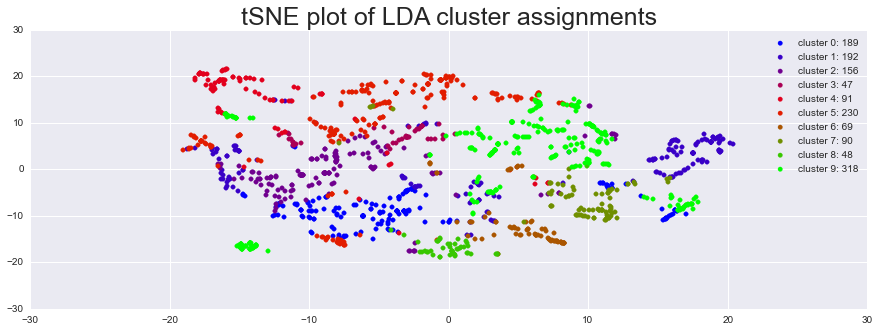

In [23]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_X_reduced = model.fit_transform(y) 
plt.figure(figsize=(15,5))
cluster = y.argmax(axis=1)
colors = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, cluster.max()+1)))
for i,c in enumerate(colors):
    n_in_cluster = np.sum(i==cluster)
    plt.scatter(tsne_X_reduced[i==cluster,0], tsne_X_reduced[i==cluster,1], color=c, label="cluster %i: %i"%(i,n_in_cluster))
plt.xlim(-30,30)
plt.legend()
plt.title("tSNE plot of LDA cluster assignments", size=25)

Comparing that to the results of the bioinformatician, we can see that the clusters found in the LDA model is not similar.

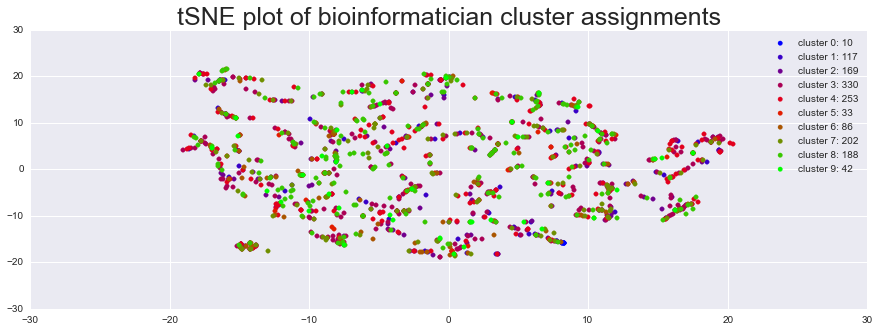

In [24]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_X_reduced = model.fit_transform(y) 
plt.figure(figsize=(15,5))
cluster = t_train
colors = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, cluster.max()+1)))
for i,c in enumerate(colors):
    n_in_cluster = np.sum(i==cluster)
    plt.scatter(tsne_X_reduced[i==cluster,0], tsne_X_reduced[i==cluster,1], color=c, label="cluster %i: %i"%(i,n_in_cluster))
plt.xlim(-30,30)
plt.legend()
plt.title("tSNE plot of bioinformatician cluster assignments", size=25)

When plotting a cluster map, we see that some of the gene expressions plays a big role compared to others (even more than for the Stan modelling).

Extracting theta...


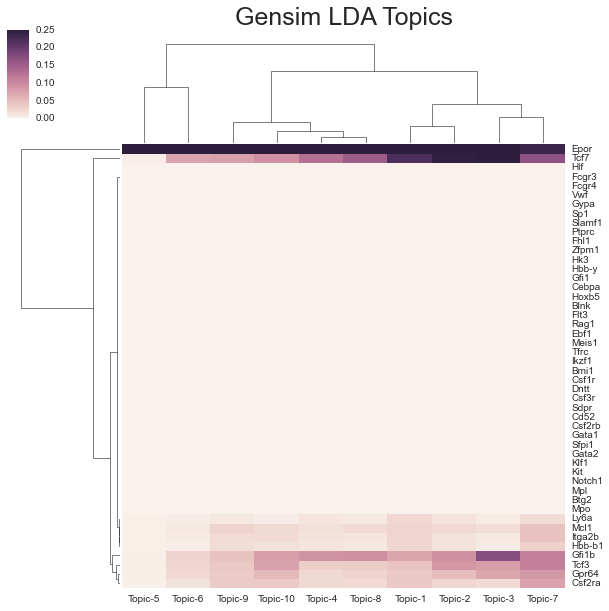

In [35]:
print "Extracting theta..."
theta = np.zeros((10, len(genes)))
for i in range(ntopics):
    theta_i = lda.get_topic_terms(i)
    for j in range(len(theta_i)):
        w_id, prob = theta_i[j]
        theta[i, j] = prob


data = pd.DataFrame(data=theta.T,index=genes, columns=["Topic-%i"%(i+1) for i in range(ntopics)])
cg = sns.clustermap(data,vmax=0.25,metric='euclidean',col_cluster=True,row_cluster=True)
out = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_col_dendrogram.set_title('Gensim LDA Topics',size=25)

## Conclusion

We have trained two different LDA models in order to find clusters in the gene expression dataset. The hypothesis was that we could find clusters equivalent to the ones given by the bioinformatician. This was not possible. From plotting using tSNE we did find some clusters, but it is highly dubious whether these clusters would have a direct link to biology. Future work would be to exploratively investigate the clusters found by the LDA model.

## References

Paul, Franziska, et al. "Transcriptional heterogeneity and lineage commitment in myeloid progenitors." Cell 163.7 (2015): 1663-1677 

Blei, David, et al. "Latent Dirichlet allocation." Journal of Machine Learning Research (2003): 993-1022